In [20]:
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import gym
from tqdm import tqdm
import collections

import sys
sys.path.append('../taylor_master/lib/env/')
from threedmountain_car import ThreeDMountainCarEnv

from dqn import q_network
import trrbm
import utils

N_MAPPED = 5000
target_env = ThreeDMountainCarEnv()

def load_samples(path):
    with open(path, "rb") as f:
        return pickle.load(f)
    
def unpack_samples(samples, action_encoder, fit_encoder=True):
    """
    to take source and target random samples output by taylor_master/lib/instance_sampler.py 
    and format in model-ready vectors
    """
    unpacked = []
    actions = []
    for sample in samples:
        state = np.array(sample[0])
        state_prime = np.array(sample[2])
        reward = np.array(sample[3])
        terminal = np.array(int(sample[4]))
        
        # need to one-hot-encode the action 
        action = [int(sample[1])]
        
        if action_encoder is not None:
            unpacked.append(np.concatenate([state,state_prime]))
            actions.append(action)
        else:
            unpacked.append(np.concatenate([state,state_prime,action]))
            
    if action_encoder is not None:
        if fit_encoder == True:
            action_encoder.fit(np.array(actions).reshape(-1,1))
        actions = action_encoder.transform(np.array(actions).reshape(-1,1)).astype(float)
        unpacked = np.concatenate([unpacked,actions],axis=1)
    else:
        unpacked = np.stack(unpacked)
    return action_encoder, unpacked

def unpack_episodes(episodes, action_encoder, fit_encoder=False):
    """
    to take source optimal samples (list of episodes) and format in model-ready vectors
    """
    samples = []
    for episode in episodes:
        for sample in episode:
            samples.append(sample)
    _, unpacked = unpack_samples(samples, action_encoder, fit_encoder=False)
    return unpacked
    
def even_out_samplesizes(samples1, samples2):
    """
    if there are more of source/target task samples than the other - randomly tiles the lesser
    sample size to even out sample sizes
    """
    if len(samples1) < len(samples2):
        samples1 = np.tile(samples1,[np.math.ceil(len(samples2)/(len(samples1))),1])
        np.random.shuffle(samples1)
        samples1 = samples1[:len(samples2)]
        
    if len(samples1) > len(samples2):
        samples2 = np.tile(samples2,[np.math.ceil(len(samples1)/(len(samples2))),1])
        np.random.shuffle(samples2)
        samples2 = samples2[:len(samples1)]
        
    return samples1, samples2


def prepare_target_triplets(target_mapped,state_size,action_size):
    """
    to separate state, action, and transition state matrixes
    """

    target_states = target_mapped[:,:state_size]
    target_states_prime = target_mapped[:,state_size:-action_size]
    target_actions = target_mapped[:,-action_size:]
    actions_greedy = np.argmax(target_actions,axis=1)

    #actions_probabilities = (np.exp(-target_actions)/np.sum(np.exp(-target_actions),axis=1).reshape(-1,1))
    #actions_sampled = np.random.multinomial(1, actions_probabilities[0], N_ACT_SAMPLES).argmax(1)

    return target_states, target_states_prime, actions_greedy.reshape(-1,1)

def generate_rewards(env,states,actions):
    """
    runs step in actual environment to generate reward for that (s,a) tuple
    COMMENT: this is completely unrealistic and also inaccurate; inaccurate since the reward
    should be associated with the (s,a,s') tuple, and unrealistic b/c in real life it would (most likley)
    be impossible to chose the state an agent is in outside bounds of moving through state space
    one step at a time
    """
    # for now just taking the actual environment as the black box function
    assert len(states) == len(actions)
    rewards = []
    for state, action in zip(states,actions):
        env.state = state
        next_state, reward, done, info = env.step(action[0])
        rewards.append(reward)
    return np.array(rewards).reshape(-1,1)
    
    
def main():
    
    source_random_path = '../taylor_master/data/2d_instances.pkl'
    target_random_path = '../taylor_master/data/3d_instances.pkl'
    source_optimal_path = '../taylor_master/data/optimal_instances.pkl'

    # load source task random samples
    source_action_encoder, source_random = unpack_samples(load_samples(source_random_path),OneHotEncoder(sparse=False))

    # load target task random samples
    target_action_encoder, target_random = unpack_samples(load_samples(target_random_path),OneHotEncoder(sparse=False))


    # prepare samples
    source_random, target_random = even_out_samplesizes(source_random, target_random)
    source_scaler, source_random = utils.standardize_samples(source_random)
    target_scaler, target_random = utils.standardize_samples(target_random)

    # load the TrRBM model

    rbm = trrbm.RBM(
        name = "TrRBM",
        v1_size = source_random.shape[1], 
        h_size = 100, 
        v2_size = target_random.shape[1], 
        n_data = source_random.shape[0], 
        batch_size = 100, 
        learning_rate = 0.000001,
        num_epochs = 100, 
        n_factors = 40,
        k = 1,
        use_tqdm = True,
        show_err_plt = True
    )

    # train the TrRBM model
    errs = rbm.train(source_random, target_random)

    if rbm.show_err_plt:
        plt.plot(range(len(rbm.cost)), rbm.cost)
        plt.title('TrRBM training reconstruction error')
        plt.xlabel('epoch')
        plt.ylabel('avg reconstruction error')
        plt.show()

    # load source task optimal instances
    source_optimal = unpack_episodes(load_samples(source_optimal_path), source_action_encoder, fit_encoder=False)
    source_optimal = source_scaler.transform(source_optimal)

    # map to target instances
    print('DEBUG: mapping instances over using TrRBM')
    np.random.shuffle(source_optimal)
    target_mapped = rbm.v2_predict(source_optimal[:N_MAPPED])
    target_mapped = target_scaler.inverse_transform(target_mapped)

    # prepare target instances (i.e. decode action; split s from s')
    print('DEBUG: preparing target instances')
    action_size = int(target_action_encoder.feature_indices_[-1])
    state_size = int((target_mapped.shape[1]-target_action_encoder.feature_indices_[-1])/2)
    target_states, target_states_prime, target_actions = prepare_target_triplets(target_mapped,state_size,action_size)

    # get rewards from black-box model of reward function
    print('DEBUG: generating black-box rewards')
    rewards = generate_rewards(target_env,target_states,target_actions) + 1.5

    # use transferred tuples to learn initial target policy \pi_{T}^{o} (as Q network)

    dqn = q_network(discount_rate = 0.9
                 ,mem_size = 5000
                 ,sample_size = 1000
                 ,n_input_units = state_size
                 ,n_output_units = action_size
                 ,n_hidden_layers = 2
                 ,n_hidden_units = 32
                 ,activation = tf.nn.relu
                 ,opt = tf.train.MomentumOptimizer
                 ,opt_kws = {'learning_rate':0.00001,'momentum':0.2}
                 )

    dqn.initialize_graph()
    dqn.open_session()
    dqn.initialize_new_variables()

    dqn.add_new_obvs(target_states, target_actions, target_states_prime, rewards)
    _states, _actions, _transitions, _rewards = dqn.get_memory_sample(dqn.mem_size)
    dqn.run_training(60, _states, _actions, _transitions, _rewards)
    dqn.plot_loss() 


    # use initial target policy and learn as we go

    N_EPISODES = 500
    N_EPOCHS = 60
    RETRAIN_PERIOD = 5000
    EPSILON = 0.2
    INI_STEPS_RETRAIN = 5000

    pbar = tqdm(range(N_EPISODES))
    episode_counter = collections.Counter()
    steps_counter = collections.Counter()
    instances = []
    for episode in pbar:
        target_env.reset()
        done = False
        while done == False:
            steps_counter['steps'] += 1
            episode_counter[episode] += 1
            state = np.array(target_env.state).reshape(1,-1)
            # epsilon-greedily take next action from network
            if np.random.random_sample() > EPSILON:
                action = dqn.get_next_action(state)[0]
            else:
                action = target_env.action_space.sample()
            next_state, reward, done, _ = target_env.step(action)

            dqn.add_new_obvs(state.reshape(1,-1),np.array([action]).reshape(1,-1),next_state.reshape(1,-1),np.array(reward).reshape(1,-1))
            if steps_counter['steps'] == INI_STEPS_RETRAIN or (steps_counter['steps'] > INI_STEPS_RETRAIN and steps_counter['steps'] % RETRAIN_PERIOD == 0):
                print(steps_counter['steps'])
                break

                _states, _actions, _transitions, _rewards = dqn.get_memory_sample(dqn.mem_size)
                dqn.run_training(N_EPOCHS, _states, _actions, _transitions, _rewards)
            instances.append([state,action,next_state,reward,done])
            target_env.render()

        if len(episode_counter) > 20 and np.all(np.array(list(episode_counter)[-20:]) <= 1000) == True:
            break



    target_env.close()    
    print('training complete!!!')

    
    return instances, episode_counter
    
if __name__ == '__main__':
    #instances, episode_counter =  main()
    print('done')

done


squared reconstruction average batch error: 203.823428125: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


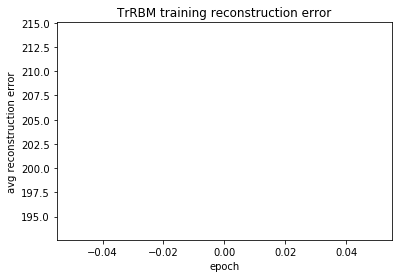

DEBUG: mapping instances over using TrRBM
DEBUG: preparing target instances
DEBUG: generating black-box rewards


In [21]:
source_random_path = '../taylor_master/data/2d_instances.pkl'
target_random_path = '../taylor_master/data/3d_instances.pkl'
source_optimal_path = '../taylor_master/data/optimal_instances.pkl'

# load source task random samples
source_action_encoder, source_random = unpack_samples(load_samples(source_random_path),OneHotEncoder(sparse=False))

# load target task random samples
target_action_encoder, target_random = unpack_samples(load_samples(target_random_path),OneHotEncoder(sparse=False))


# prepare samples
source_random, target_random = even_out_samplesizes(source_random, target_random)
source_scaler, source_random = utils.standardize_samples(source_random)
target_scaler, target_random = utils.standardize_samples(target_random)

# load the TrRBM model

rbm = trrbm.RBM(
    name = "TrRBM",
    v1_size = source_random.shape[1], 
    h_size = 100, 
    v2_size = target_random.shape[1], 
    n_data = source_random.shape[0], 
    batch_size = 100, 
    learning_rate = 0.000001,
    num_epochs = 1, 
    n_factors = 40,
    k = 1,
    use_tqdm = True,
    show_err_plt = True
)

# train the TrRBM \model
errs = rbm.train(source_random, target_random)

if rbm.show_err_plt:
    plt.plot(range(len(rbm.cost)), rbm.cost)
    plt.title('TrRBM training reconstruction error')
    plt.xlabel('epoch')
    plt.ylabel('avg reconstruction error')
    plt.show()

# load source task optimal instances
source_optimal = unpack_episodes(load_samples(source_optimal_path), source_action_encoder, fit_encoder=False)
source_optimal = source_scaler.transform(source_optimal)

# map to target instances
print('DEBUG: mapping instances over using TrRBM')
np.random.shuffle(source_optimal)
target_mapped = rbm.v2_predict(source_optimal[:N_MAPPED])
target_mapped = target_scaler.inverse_transform(target_mapped)

# prepare target instances (i.e. decode action; split s from s')
print('DEBUG: preparing target instances')
action_size = int(target_action_encoder.feature_indices_[-1])
state_size = int((target_mapped.shape[1]-target_action_encoder.feature_indices_[-1])/2)
target_states, target_states_prime, target_actions = prepare_target_triplets(target_mapped,state_size,action_size)

# get rewards from black-box model of reward function
print('DEBUG: generating black-box rewards')
rewards = generate_rewards(target_env,target_states,target_actions) + 1.5



loss: 3068.55859375: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]    


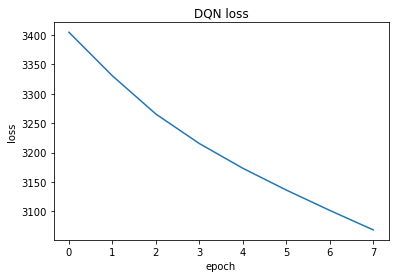

In [22]:
# use transferred tuples to learn initial target policy \pi_{T}^{o} (as Q network)

dqn = q_network(discount_rate = 0.9
             ,mem_size = 5000
             ,sample_size = 1000
             ,n_input_units = state_size
             ,n_output_units = action_size
             ,n_hidden_layers = 2
             ,n_hidden_units = 32
             ,activation = tf.nn.relu
             ,opt = tf.train.MomentumOptimizer
             ,opt_kws = {'learning_rate':0.00001,'momentum':0.2}
             )

dqn.initialize_graph()
dqn.open_session()
dqn.initialize_new_variables()

dqn.add_new_obvs(target_states, target_actions, target_states_prime, rewards)
_states, _actions, _transitions, _rewards = dqn.get_memory_sample(dqn.mem_size)
dqn.run_training(8, _states, _actions, _transitions, _rewards)
dqn.plot_loss() 

In [23]:
    # use initial target policy and learn as we go

    N_EPISODES = 500
    N_EPOCHS = 80
    RETRAIN_PERIOD = 5000
    EPSILON = 0.5
    EPSILON_DECAY = 0.9999
    INI_STEPS_RETRAIN = 1000

    pbar = tqdm(range(N_EPISODES))
    episode_counter = collections.Counter()
    steps_counter = collections.Counter()
    instances = []
    rewards = []
    for episode in pbar:
        target_env.reset()
        done = False
        while True:
            steps_counter['steps'] += 1
            episode_counter[episode] += 1
            state = np.array(target_env.state).reshape(1,-1)
            # epsilon-greedily take next action from network
            if np.random.random_sample() > EPSILON:
                action = dqn.get_next_action(state)[0]
            else:
                action = target_env.action_space.sample()
            next_state, reward, done, _ = target_env.step(action)

            dqn.add_new_obvs(state.reshape(1,-1),np.array([action]).reshape(1,-1),next_state.reshape(1,-1),np.array(reward).reshape(1,-1))
            if steps_counter['steps'] == INI_STEPS_RETRAIN or (steps_counter['steps'] > INI_STEPS_RETRAIN and steps_counter['steps'] % RETRAIN_PERIOD == 0):
                print(steps_counter['steps'])
                _states, _actions, _transitions, _rewards = dqn.get_memory_sample(dqn.mem_size)
                dqn.run_training(N_EPOCHS, _states, _actions, _transitions, _rewards)
            #instances.append([state,action,next_state,reward,done])
            rewards.append(reward)
            target_env.render_orthographic()
            
            EPSILON = EPSILON_DECAY*EPSILON
            
            if done == False:
                print('episode {} completed'.format(len(episode_counter)))
                break

        if len(episode_counter) > 20 and np.all(np.array(list(episode_counter)[-20:]) <= 1000) == True:
            break



    target_env.close()    
    print('training complete!!!')

  2%|▏         | 8/500 [00:00<04:49,  1.70it/s]

episode 1 completed
episode 2 completed
episode 3 completed
episode 4 completed
episode 5 completed
episode 6 completed
episode 7 completed
episode 8 completed
episode 9 completed
episode 10 completed
episode 11 completed
episode 12 completed
episode 13 completed


  4%|▍         | 19/500 [00:01<02:25,  3.30it/s]

episode 14 completed
episode 15 completed
episode 16 completed
episode 17 completed
episode 18 completed
episode 19 completed
episode 20 completed
episode 21 completed
training complete!!!


In [41]:
import pickle

output = {'description':'this is a description of the experiment'
          ,'rewards':rewards
          ,'episode_counter':episode_counter
          ,'episode_total_reward':episode_total_reward
          ,'params':{}}
    
file = 'TrRBM_exp_{}.p'.format(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
with open(file, 'wb') as f:
    pickle.dump(output,f)

In [43]:
with open(file,'rb') as f:
    a = pickle.load(f)

In [8]:
.9999**5000

0.6065154956247782

In [ ]:
steps_counter = collections.Counter()

In [ ]:
steps_counter['steps']

In [ ]:
d = collections.deque(['a','b','c'])

In [25]:
np.array(episode_counter)

array(Counter({0: 1001}), dtype=object)

In [ ]:
state,action,next_state,reward

In [ ]:
state.shape

In [ ]:
np.array([[reward]]).T[0]

In [ ]:
rewards.T[0]

In [ ]:
_states.shape

In [ ]:
np.array(np.array(state))

In [ ]:
d = collections.deque([1,2,3])

In [ ]:
len(d)

In [15]:
_actions[:1000]

array([array([1]), array([3]), array([2]), array([1]), array([0]),
       array([2]), array([2]), array([4]), array([0]), array([0]),
       array([4]), array([3]), array([2]), array([3]), array([4]),
       array([4]), array([0]), array([4]), array([3]), array([1]),
       array([2]), array([3]), array([4]), array([4]), array([3]),
       array([4]), array([2]), array([0]), array([0]), array([4]),
       array([0]), array([0]), array([0]), array([1]), array([4]),
       array([2]), array([4]), array([2]), array([0]), array([1]),
       array([3]), array([1]), array([4]), array([4]), array([0]),
       array([4]), array([0]), array([4]), array([0]), array([2]),
       array([1]), array([1]), array([4]), array([3]), array([3]),
       array([1]), array([0]), array([1]), array([2]), array([1]),
       array([0]), array([1]), array([1]), array([1]), array([3]),
       array([0]), array([4]), array([3]), array([2]), array([3]),
       array([3]), array([1]), array([0]), array([0]), array([

In [ ]:
target_states.shape

In [ ]:
target_states, target_actions, target_states_prime, rewards

In [16]:
import collections

d = collections.Counter([1,2,3])

In [27]:
np.all(np.array([1,2,3]) < 4)

True

In [18]:
list(d.keys())

[1, 2, 3]

In [10]:
import tensorflow as tf

a = tf.Variable([1.0,2.0,3.0])

In [11]:

b = tf.Variable([0.0,0.0,0.0])

In [ ]:
saver = tf.train.Saver()